In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.2f}'.format)

## Reading dataset

Observation:
- From looking at the dataset documentation we observe that many of the categorical features contain a value which can be 'NA' or 'None' string, which indicates that feature is not present. 
- By default `pd.read_csv` would interpret this as a missing values which is not the case.

Solution:
- Change the list of strings to be intepreted as missing values, such that only empty string '' is considered as a missing values


In [3]:
file ='house-prices.csv'
df = pd.read_csv(file, na_values = [''],keep_default_na=False)
df.drop(['Order', 'PID'], axis=1, inplace=True)

In [4]:
df.isna().sum().sum()

11670

In [5]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,20,RL,75.00,10170,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,160,RM,21.00,2001,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,20,RL,70.00,10552,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,190,RM,60.00,10120,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


In [6]:
df.shape

(2430, 80)

Observation:
- There are 80 features and 2430 entries
- We observe there's a mix of categorical and numerical features

Solution:
- From reading the documentation we can know which features should correspond to a certa type ('nominal', 'ordinal', 'discrete' and 'continuous')
- Change the datatypes of the read dataframe to be compatible with the know variable types

In [7]:
# List of nominal features
nominal_features = [
    "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour",
    "Lot Config", "Neighborhood", "Condition 1", "Condition 2", "Bldg Type",
    "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd",
    "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type",
    "Misc Feature", "Sale Type", "Sale Condition"
]

ordinal_features = [
    "Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond",
    "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure",
    "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", 
    "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual",
    "Garage Cond", "Paved Drive", "Pool QC", "Fence"
]

discrete_features = [
    "Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath",
    "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd", "Fireplaces", "Garage Yr Blt",
    "Garage Cars", "Mo Sold", "Yr Sold", "Year Built", "Year Remod/Add"
]
continuous_features = [
    "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF",
    "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area",
    "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch",
    "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val",
    "Lot Frontage", "Lot Area", "Mas Vnr Area"
]

for col in nominal_features:
        df[col] = df[col].astype('object')

for col in ordinal_features:
        df[col] = df[col].astype('object')

df['Overall Cond'] = df['Overall Cond'].astype('str')
df['Overall Qual'] = df['Overall Qual'].astype('str')

for col in discrete_features:
        df[col] = df[col].astype('Int64')

for col in continuous_features:
        df[col] = df[col].astype('float64')


# Data Cleaning

Next we'll perform the data cleaning operations treating missing values, outliers and inconsistencies. This will be performed idependently for the different types of variables.

## Nominal Features

In [8]:
print(f'Number of ordinal features: {len(nominal_features)}')

Number of ordinal features: 23


__Missing values__

In [9]:
print(f'Total missing values in ordinal features: {df[nominal_features].isna().sum().sum()}')

Total missing values in ordinal features: 4763


In [10]:
df_ordinal_missing = df[nominal_features].isna().sum().to_frame(name='total')
df_ordinal_missing = df_ordinal_missing[df_ordinal_missing['total']!=0].sort_values('total', ascending=False)
df_ordinal_missing['percentage'] = df_ordinal_missing['total']/len(df)*100
df_ordinal_missing

,total,percentage
Misc Feature,2340,96.30
Alley,2267,93.29
Garage Type,136,5.60
Mas Vnr Type,20,0.82


Observation:
- According to the documentation, all 4 features with missing values contain a category for 'NA' (not available)
- From a quick check of the original CSV file, it is highly probable that these missing values should instead be 'NA', corresponding to cases where such a feature is not present

Solution:
- Replace the missing values with 'NA'
- Replace all existing values of 'None' with 'NA'

In [11]:
# Replace missing values with 'None'
for feature in ['Misc Feature', 'Alley', 'Garage Type', 'Mas Vnr Type']:
    df[feature] = df[feature].fillna('NA')
    
for feature in nominal_features:
    df[feature].replace('None','NA', inplace=True)

In [12]:
print("Missing values in Nominal columns after cleaning: ", df[nominal_features].isna().sum().sum())

Missing values in Nominal columns after cleaning:  0


__Feature distribution__

We next observe the distribution of all the features

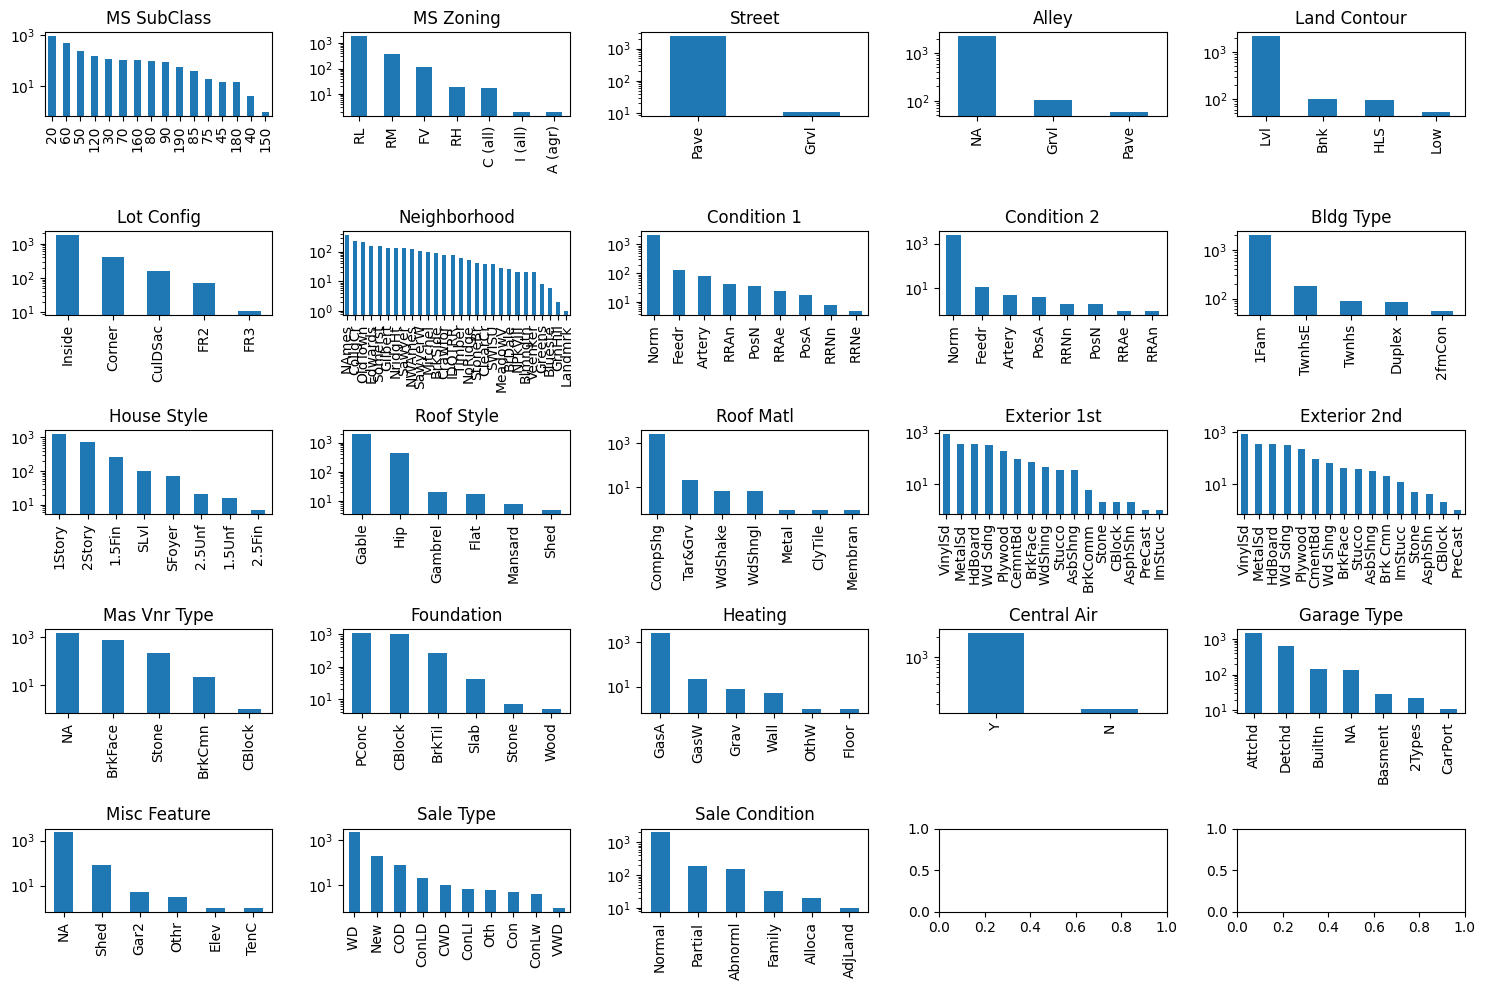

In [13]:
n_cols = 5
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, col in enumerate(nominal_features):
    r, c = np.divmod(i, n_cols)
    df[col].value_counts().plot(kind='bar', ax=axs[r, c], logy=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

Observation
- For most features there's a a difference in 1 or more orders of magnitude between most and least frequent values

Solution
- As part of Outlier removal, we may decide to remove the entries whose values in a certain feature correpond to the least represented categories

__Outlier removal__

Our objective for this model is to predict the Sale Price of "normal" residential homes, without considering very rare or specific types of propetries that are represented by very few entries in the dataset.
Hence, our strategy for outlier removal will be to remove entries which have categories or range of values that fall outside of the more populated categories or range of values.
As said, these may represent real property purchases, but they like are properties other than "normal" residential homes. For example, there's a single entry for which the zoning classification "MS Zoning" is Industrial "I". It makes sense to remove since we aim at modeling only residential properties and not industrial properties.

We also stipulated that we can affort to drop a maximum of 5% of the total dataset entries (initially there are 2430), in order to assure we still have a statistically representative dataset for training.


__Nominal Features: Categories which populated with minimum of entries__

In [14]:
print(f'{"Feature":<20}|{"Category_MinCount":<20}|{"MinCount":<20}')
print("-"*50)
for feature in nominal_features:
    
    # Get the number of entries per category
    category_counts = df[feature].value_counts()
    min_count_category = category_counts.idxmin()

    # Display the counts
    print(f'{feature:<20}|{min_count_category:<20}|{min(category_counts):<20}')

Feature             |Category_MinCount   |MinCount            
--------------------------------------------------
MS SubClass         |150                 |1                   
MS Zoning           |I (all)             |2                   
Street              |Grvl                |11                  
Alley               |Pave                |59                  
Land Contour        |Low                 |54                  
Lot Config          |FR3                 |11                  
Neighborhood        |Landmrk             |1                   
Condition 1         |RRNe                |5                   
Condition 2         |RRAe                |1                   
Bldg Type           |2fmCon              |56                  
House Style         |2.5Fin              |7                   
Roof Style          |Shed                |5                   
Roof Matl           |Metal               |1                   
Exterior 1st        |PreCast             |1                   
Exte

Observation:
- For about half of the features there's at least one category populated with just 1 or 2 entries

Solution:
- We decide to remove the entries for which there's <=2 counts of a given category;
- We check how many entries we dropped

In [15]:
threshold = 2

for feature in nominal_features:

    category_counts = df[feature].value_counts()
    # Identify categories with counts <= threshold
    low_count_categories = category_counts[category_counts <= threshold].index
    # Filter out entries with low count categories
    df = df[~df[feature].isin(low_count_categories)]

In [16]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 1.36%


## Ordinal Features

In [17]:
print(f'Number of ordinal features: {len(ordinal_features)}')

Number of ordinal features: 23


__Missing values__

In [18]:
print(f'Total missing values: {df[ordinal_features].isna().sum().sum()}')

Total missing values: 6201


In [19]:
df_ordinal_missing = df[ordinal_features].isna().sum().to_frame(name='total')
df_ordinal_missing = df_ordinal_missing[df_ordinal_missing['total']!=0].sort_values('total', ascending=False)
df_ordinal_missing['percentage'] = df_ordinal_missing['total']/len(df)*100
df_ordinal_missing

,total,percentage
Pool QC,2387,99.58
Fence,1915,79.89
Fireplace Qu,1169,48.77
Garage Finish,135,5.63
Garage Qual,135,5.63
Garage Cond,135,5.63
Bsmt Exposure,67,2.80
BsmtFin Type 2,65,2.71
Bsmt Qual,64,2.67
Bsmt Cond,64,2.67


Observation:
- Except for 'Electrical' all other features have a value which corresponds to 'None' according to the dataset doc 
- From a quick check of the original CSV file, it is highly probable that these missing values should instead be 'None', corresponding to cases where such a feature is not present

Solution:
- Replace the missing value for 'Electrical' with the mode
- Replace the missing values of remaining features with 'NA'
- Replace all existing values of 'None' with 'NA'

In [20]:
# Replace missing values with the mode
mode_value = df['Electrical'].mode()[0]
df['Electrical'].fillna(mode_value, inplace=True)

In [21]:
# Replace missing values with 'None'
df[ordinal_features] = df[ordinal_features].fillna('NA')

df[ordinal_features].replace('None','NA', inplace=True)

In [22]:
print("Missing values in Ordinal columns after cleaning: ", df[ordinal_features].isna().sum().sum())

Missing values in Ordinal columns after cleaning:  0


__Feature distribution__

We next observe the distribution of all the features

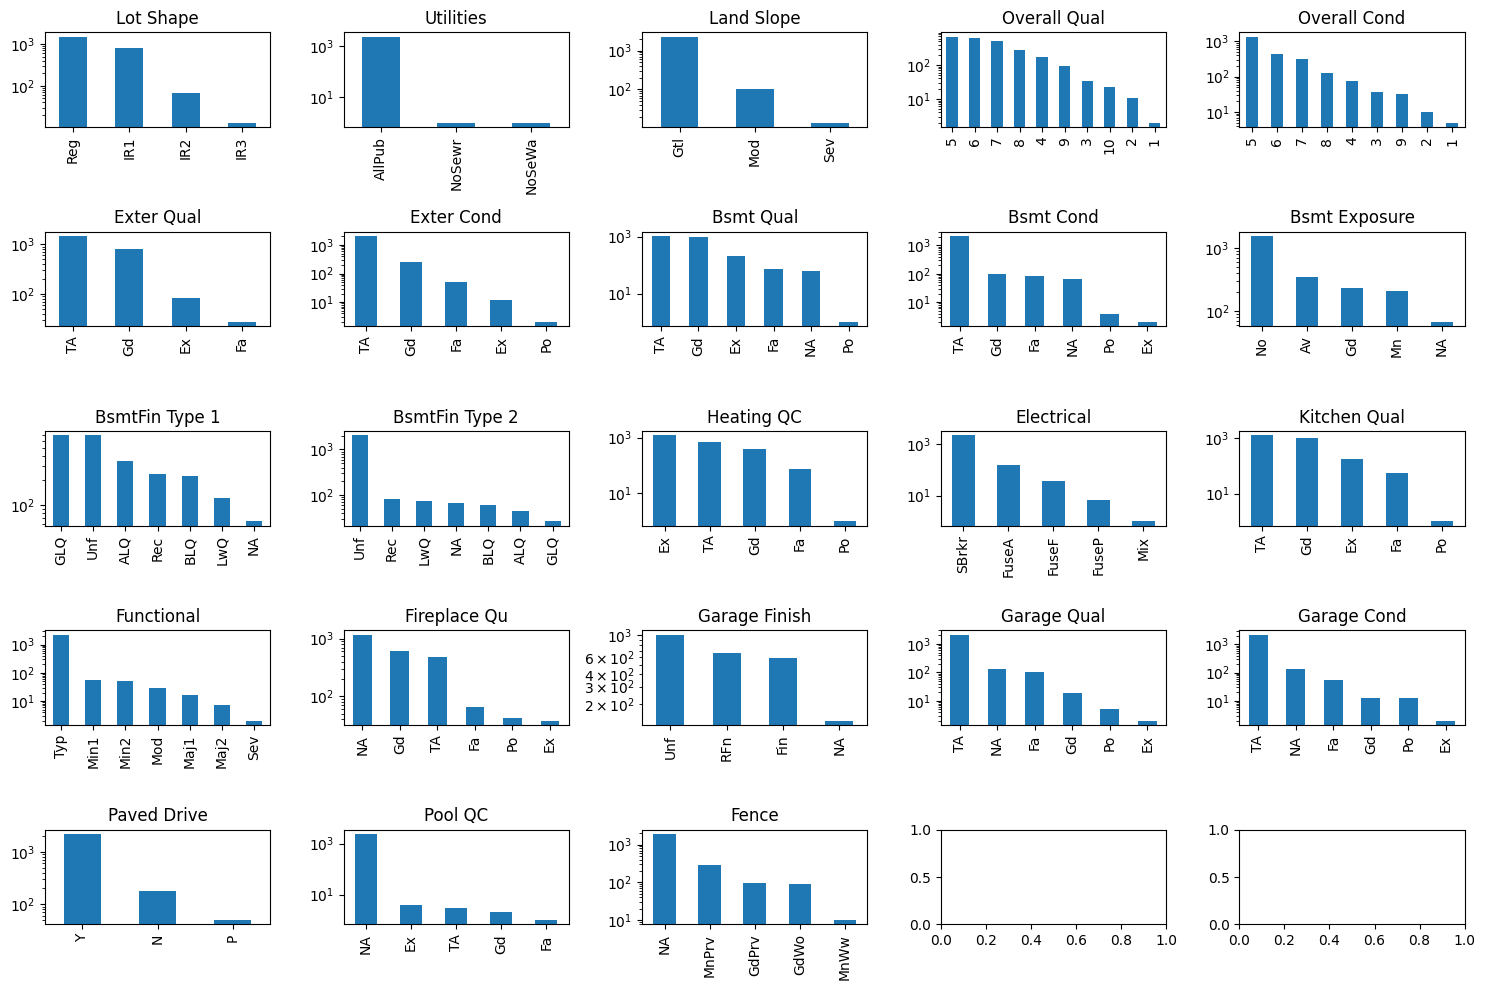

In [23]:
n_cols = 5
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, col in enumerate(ordinal_features):
    r, c = np.divmod(i, n_cols)
    df[col].value_counts().plot(kind='bar', ax=axs[r, c], logy=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

Observation
- For most features there's a a difference in 1 or more orders of magnitude between most and least frequent values
- The entries which populated categories with very small counts are good candidates for being considered as outliers in our model as explained before

__Outlier removal__

We start by obtaining the categories with the minimum of entries for all features.

In [24]:
print(f'{"Feature":<20}|{"MinCountCategory":<20}|{"MinCount":<20}')
print("-"*50)
for feature in ordinal_features:
    
    # Get the number of entries per category
    category_counts = df[feature].value_counts()
    min_count_category = category_counts.idxmin()

    # Display the counts
    print(f'{feature:<20}|{min_count_category:<20}|{min(category_counts):<20}')

Feature             |MinCountCategory    |MinCount            
--------------------------------------------------
Lot Shape           |IR3                 |13                  
Utilities           |NoSewr              |1                   
Land Slope          |Sev                 |14                  
Overall Qual        |1                   |2                   
Overall Cond        |1                   |5                   
Exter Qual          |Fa                  |27                  
Exter Cond          |Po                  |2                   
Bsmt Qual           |Po                  |1                   
Bsmt Cond           |Ex                  |2                   
Bsmt Exposure       |NA                  |67                  
BsmtFin Type 1      |NA                  |64                  
BsmtFin Type 2      |GLQ                 |26                  
Heating QC          |Po                  |1                   
Electrical          |Mix                 |1                   
Kitc

Observation:
- Again, for about half of the features there's at least one category populated with just 1 or 2 entries

Solution:
- We decide to remove the entries for which there's <=2 counts of a given category;
- We check how many entries we dropped

In [25]:
threshold = 2

for feature in ordinal_features:

    category_counts = df[feature].value_counts()
    # Identify categories with counts <= threshold
    low_count_categories = category_counts[category_counts <= threshold].index
    # Filter out entries with low count categories
    df = df[~df[feature].isin(low_count_categories)]


In [26]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 2.18%


## Discrete features

In [27]:
print('Number of numerical discrete features:', len(discrete_features))

Number of numerical discrete features: 14


__Missing Values:__

In [28]:
print(f'Total missing values: {df[discrete_features].isna().sum().sum()}')

Total missing values: 134


In [29]:
df_discrete_missing = df[discrete_features].isna().sum().to_frame(name='total')
df_discrete_missing = df_discrete_missing[df_discrete_missing['total']!=0].sort_values('total', ascending=False)
df_discrete_missing['percentage'] = df_discrete_missing['total']/len(df)*100
df_discrete_missing

,total,percentage
Garage Yr Blt,131,5.51
Bsmt Full Bath,1,0.04
Bsmt Half Bath,1,0.04
Garage Cars,1,0.04


Observation:
- 'Garage Yr Blt' is the feature with more missing values, these correspond to entries where there is no garage. It's not obvious which value to assign in these cases, the feature definition doesn't make sense for these cases.
- For 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars' the number of missing values is very small

Solution: 
- Check correlation between 'Year Blt' and 'Garage Yr Blt', and if correlation is high we decide to drop the 'Garage Yr Blt' feature altogether
- For 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars', fill missing values with the mode.


In [30]:
df[df['Garage Yr Blt'].isna()]['Garage Type'].value_counts()

Garage Type
NA        129
Detchd      2
Name: count, dtype: int64

In [31]:
print(f"Correlation of 'Garage Yr Blt' with 'SalePrice': {df['Garage Yr Blt'].corr(df['Year Built'])}")

Correlation of 'Garage Yr Blt' with 'SalePrice': 0.8363262947400202


As explained before, since the correlation is very high, we decide to drop the feature 'Garage Yr Blt'

In [32]:
df.drop('Garage Yr Blt', axis=1, inplace=True)
discrete_features = list(set(discrete_features) - set(['Garage Yr Blt']))

In [33]:
# Replace missing values with the mode
features = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']

for feature in features:
    mode_value = df[feature].mode()[0]
    df[feature].fillna(mode_value, inplace=True)

In [34]:
print(f"Missing values in discrete columns after cleaning: {df[discrete_features].isna().sum().sum()}")

Missing values in discrete columns after cleaning: 0


__Feature distribution:__

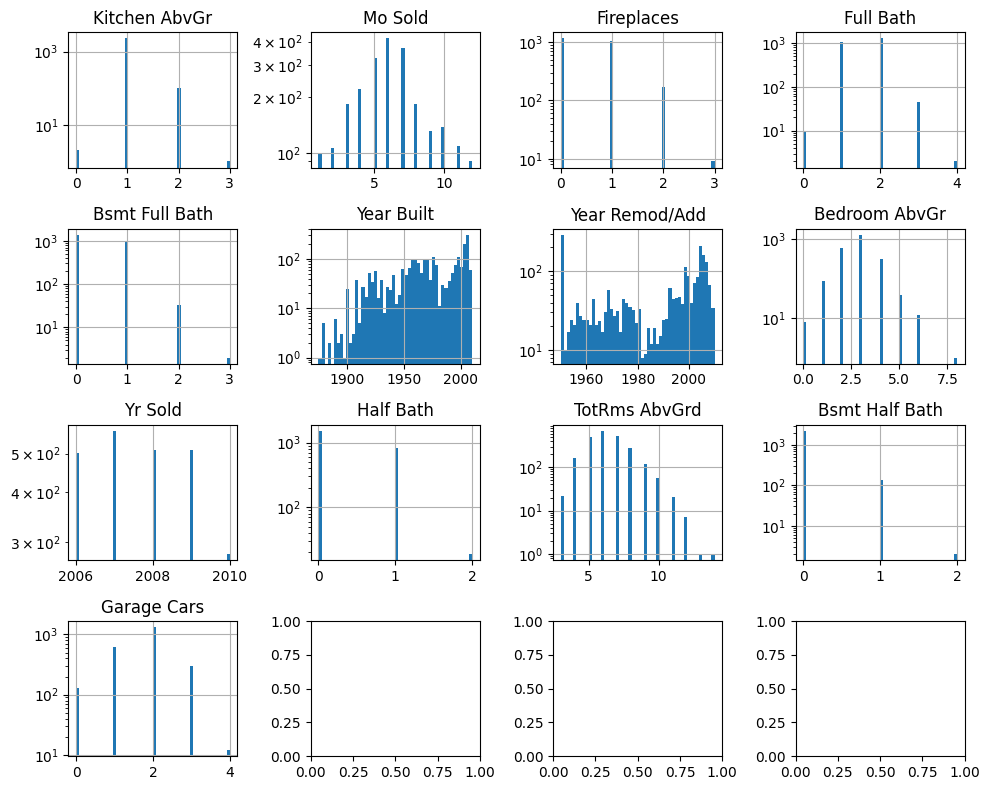

In [35]:
n_cols = 4
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 8))

for i, col in enumerate(discrete_features):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c], log=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

Observation
- For some few features there are values with very few entries (e.g. 'Bsmt full Bath' has very few entries equal to 3)
- The entries popupalting these values are good candidates for being considered as outliers in our model as explained before

__Outlier removal__

Again, we start by obtaining the categories with the minimum of entries for all features.

In [36]:
print(f'{"Feature":<20}|{"MinValue":<20}|{"MinCount":<20}')
print("-"*50)
for feature in discrete_features:
    
    # Get the number of entries per category
    category_counts = df[feature].value_counts()
    min_count_category = category_counts.idxmin()

    # Display the counts
    print(f'{feature:<20}|{min_count_category:<20}|{min(category_counts):<20}')

Feature             |MinValue            |MinCount            
--------------------------------------------------
Kitchen AbvGr       |3                   |1                   
Mo Sold             |12                  |90                  
Fireplaces          |3                   |9                   
Full Bath           |4                   |2                   
Bsmt Full Bath      |3                   |2                   
Year Built          |1908                |1                   
Year Remod/Add      |1982                |8                   
Bedroom AbvGr       |8                   |1                   
Yr Sold             |2010                |280                 
Half Bath           |2                   |19                  
TotRms AbvGrd       |14                  |1                   
Bsmt Half Bath      |2                   |2                   
Garage Cars         |4                   |12                  


Observation:
- For about half of the features there's at least one value populated with just 1 or 2 entries ('Year Built'=1908, 'Bsmt Full Bath'=3, 'Full Bath'=4)

Solution:
- We decide to remove the entries for which there's a count <=2 for a given discrete value;
- We verify that the total number of dropped entries is still smaller than 5%

In [37]:
threshold = 2

for feature in discrete_features:

    category_counts = df[feature].value_counts()
    # Identify categories with counts <= threshold
    low_count_categories = category_counts[category_counts <= threshold].index
    # Filter out entries with low count categories
    df = df[~df[feature].isin(low_count_categories)]


In [38]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 3.42%


## Continuous variable

In [39]:
print('Number of numerical continuous features:', len(continuous_features))

Number of numerical continuous features: 19


__Missing Values__

In [40]:
print(f"Missing values in continuous columns: {df[continuous_features].isna().sum().sum()}")

Missing values in continuous columns: 423


In [41]:
df_continuous_missing = df[continuous_features].isna().sum().to_frame(name='total')
df_continuous_missing = df_continuous_missing[df_continuous_missing['total']!=0].sort_values('total', ascending=False)
df_continuous_missing['percentage'] = df_continuous_missing['total']/len(df)*100
df_continuous_missing

,total,percentage
Lot Frontage,402,17.13
Mas Vnr Area,20,0.85
Garage Area,1,0.04


Observation:
- Feature 'Lot Frontage' has a significant ammount of missing values, these could be from properties with no street connection, but this should be verified
- 'Mas Vnr Area' (Masonry veneer area in square feet) with missing values could also be coming from properties with no Masonry veneer surface

Solution:
- Observe relation between 'Lot Frontage' and 'Lot Config' for properties with no lot frontage.
- Check if missing values in 'Mas Vnr Area', also have 'Mas Vnr Type' equal to 'NA'
- If previous 

__Missing values in 'Lot Frontage':__

In [42]:
df[df['Lot Frontage'].isna()]['Lot Config'].value_counts()

Lot Config
Inside     224
Corner      82
CulDSac     77
FR2         16
FR3          3
Name: count, dtype: int64

Most missing values in 'Lot Frontage' correspond to lot configurations - 'Inside' and 'CulDSac' - where it seems likely that there's no street connection. We can reasonably assume that these missing values should correpond to 0 feet of street connection of the property.

In [43]:
df.loc[(df['Lot Config'].isin(['Inside', 'CulDSac'])) & (df['Lot Frontage'].isna()), 'Lot Frontage'] = 0

For the remaining missing values in the 'Lot Frontage' column, we will replace them with the median value (more robust to outliers than the mean).

In [44]:
# For the remaining missing values in the 'Lot Frontage' column, we will replace them with the median value.
median_value = df['Lot Frontage'].median()
df['Lot Frontage'].fillna(median_value, inplace=True)

__Missing values in 'Mas Vnr Area':__

In [45]:
df[df['Mas Vnr Area'].isna()]['Mas Vnr Type'].value_counts()

Mas Vnr Type
NA    20
Name: count, dtype: int64

All missing values in 'Mas Vnr Area' correspond to entries where 'Mas Vnr Type' is 'NA', hence it makes sense that these values should actually be zero.

In [46]:
df['Mas Vnr Area'].fillna(0, inplace=True)


__Missing values in 'Garage Area':__

In [47]:
df[df['Garage Area'].isna() | df['Garage Type'].isna() | df['Garage Finish'].isna() | df['Garage Qual'].isna() | df['Garage Cond'].isna()][['Garage Area','Garage Cars','Garage Type','Garage Finish','Garage Qual','Garage Cond']]   

,Garage Area,Garage Cars,Garage Type,Garage Finish,Garage Qual,Garage Cond
1565,NaN,2,Detchd,NA,NA,NA


Since the entry with missing value in for 'Garage Area' presents rather inconsistent values for remaining garage variables we decide to drop this entry. For meaning of ordinal features values check previously defined encoding.

In [48]:
df.drop(index=1565,inplace=True)

After the previous cleanup, the following reduced number of features with missing values remain:

In [49]:
print(f"Missing values in numerical continuous features after cleaning: {df[continuous_features].isna().sum().sum()}")

Missing values in numerical continuous features after cleaning: 0


__Feature Distribution__

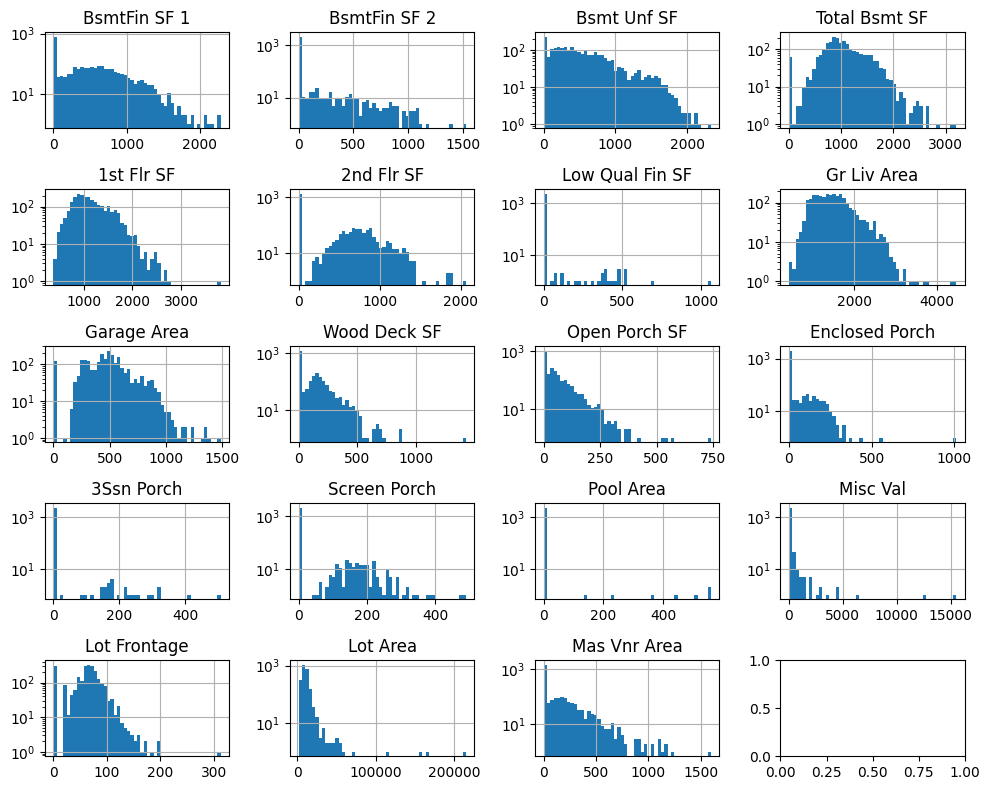

In [50]:
n_cols = 4
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,8))

for i, col in enumerate(continuous_features):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c])
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    axs[r, c].set_yscale('log')
    
plt.tight_layout()
plt.show()

Observations:

- Except for 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area', 'Lot Frontage' and 'Lot Area', all other features have most values equal to 0. 

__Outlier removal__

Observation:
- By observing the histogram distributions above, we decide to remove data points which lie far away from the main lobe of datapoints (e.g. '1st Flr SF'>3000). 

Solution:
- Remove the following:
    - '1st Flr SF' > 30000
    - 'BsmtFin SF 2' > 1250
    - 'Wood Deck SF' > 1000
    - 'Open Porch SF' > 500
    - 'Enclosed Porch' > 500
    - 'Misc Val' > 10000
    - 'Lot Frontage' > 250
    - 'Lot Area' > 100000
    - 'Mas Vnr Area' > 1500

In [51]:
df = df[
    (df['1st Flr SF'] <= 3000) &
    (df['BsmtFin SF 2'] <= 1250) &
    (df['Wood Deck SF'] <= 1000) &
    (df['Open Porch SF'] <= 500) &
    (df['Enclosed Porch'] <= 500) &
    (df['Misc Val'] <= 10000) &
    (df['Lot Frontage'] <= 250) &
    (df['Lot Area'] <= 100000) &
    (df['Mas Vnr Area'] <= 1500)
]


In [52]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 4.20%


We next plot again the feature distributions, but this time with linear scale on y-axis (counts) 

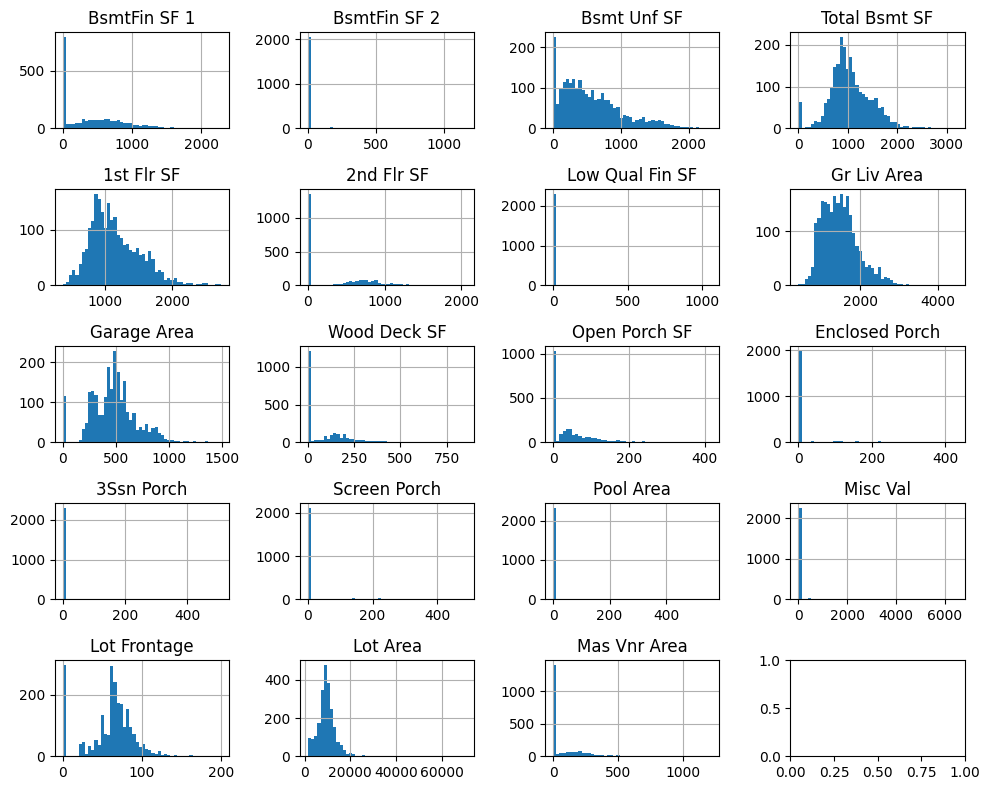

In [53]:
n_cols = 4
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,8))

for i, col in enumerate(continuous_features):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c])
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    
plt.tight_layout()
plt.show()

__Obsevation__:
- The following features have most entries equal to zero: __'BsmtFin SF 2'__, __'BsmtFin SF 2'__, __'2nd Flr SF'__, __'Low Qual Fin Sf'__, __'Wood Deck SF'__, __'Open Porch SF'__, __'Enclosed Porch'__, __'3Ssn Porch'__, __'Screen Porch'__, __'Pool Area'__, __'Misc Val'__, __'Mas Vnr Area'__
- Since having them as continuous features, doesn't add much information, they could be replaced by binary variables, which indicate the presence or not of the given feature.

## Inconsistencies

Next we'll analyse possible incosistencies among the variables related to the following characteritics:
- Basement variables
- Garage Year Built
- Finished vs living areas
- 'Year Built' vs 'Year Remod/Add'

__Basement variables__

Next we check for possible inconsistencies in Basement related features with missing values

In [54]:
basement_features = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']

We start by looking at entries where at least one feature indicates 'NA', but where this is inconsistent witht he other features.

In [55]:
q1 = '(`Bsmt Qual` == "NA") | (`Bsmt Exposure` == "NA") | (`BsmtFin Type 1` == "NA") | (`BsmtFin Type 2` == "NA")'
q2 = '~((`Bsmt Qual` == "NA") & (`Bsmt Exposure` == "NA") & (`BsmtFin Type 1` == "NA") & (`BsmtFin Type 2` == "NA") & (`BsmtFin SF 1` == 0.00) & (`BsmtFin SF 2` == 0.00) & (`Bsmt Unf SF` == 0.00) & (`Total Bsmt SF` == 0.00) & (`Bsmt Full Bath` == 0) & (`Bsmt Half Bath` == 0))'
df.query(q1).query(q2)[basement_features]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
602,Gd,TA,No,GLQ,1124.00,NA,479.00,1603.00,3206.00,1,0
875,Gd,TA,NA,Unf,0.00,Unf,0.00,1595.00,1595.00,0,0
1681,Gd,TA,NA,Unf,0.00,Unf,0.00,725.00,725.00,0,0
1726,Gd,TA,NA,Unf,0.00,Unf,0.00,936.00,936.00,0,0


Observation:
- The previous entries show some kind of inconsistency, among the variables describing the basement facilities

Solution:
- Since these are only a few entries, we'll fix the entries using common sense
- We'll populate the column `'Bsmt Exposure'` of entries 875, 1681 and 1726, where  indicates there is no basement but we there's a basement in Unfinished conditions, with `'Bsmt Exposure'=='No'` that indicates no exposure to outside

In [56]:
df.loc[602, ['BsmtFin Type 2']] = 'Unf'
df.loc[[875,1681, 1726], ['Bsmt Exposure']] = 'No'

Next we check for potential inconsistencies among the various surface features.

In [57]:
inconsistent_basement_surface = (df['BsmtFin SF 1'] + df['BsmtFin SF 2'] + df['Bsmt Unf SF']) != df['Total Bsmt SF']
inconsistent_basement_surface.sum()

0

Observation:
- The Basement surface features are consistent among for all entries

__Garage Variables__

In [58]:
garage_features = ['Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']

Again, we start by looking at entries where at least one feature indicates 'NA', but where this is inconsistent witht he other features.

In [59]:
q1 = '(`Garage Type` == "NA") | (`Garage Finish` == "NA") | (`Garage Cars` == 0) | (`Garage Area` == 0) | (`Garage Qual` == "NA") & (`Garage Cond` == "NA")'
q2 = '~((`Garage Type` == "NA") & (`Garage Finish` == "NA") & (`Garage Cars` == 0) & (`Garage Area` == 0) & (`Garage Qual` == "NA") & (`Garage Cond` == "NA"))'
df.query(q1).query(q2)[garage_features]

,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1114,Detchd,NA,1,360.00,NA,NA


Observation:
- There is one entry with inconsistent values

Solution:
- We decide to drop this entry since it's just one

In [60]:
df.drop([1114], inplace=True)

__Year Built vs Year Remod/Add vs Year Sold__

We verify that the following conditions are verified:
-  'Yr Sold' >= 'Year Remod/Add'
- 'Year Remod/Add' >= 'Year Built' 

In [61]:
df[df['Year Remod/Add'] < df['Year Built']]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice


In [62]:
q = '(`Year Built` > `Yr Sold`)'
df.query(q)[['Year Built', 'Year Remod/Add', 'Yr Sold']]

,Year Built,Year Remod/Add,Yr Sold


Observation:  
- No inconsistencies observed between 'Year Built' and 'Year Remod/Add'

__Misc Feature and Misc Val__

When there is no 'Misc Feature' the corresponding 'Misc Val' should be 0 

In [63]:
q = '(`Misc Feature` ==  "NA") & (`Misc Val` != 0)'
df.query(q)[['Misc Feature', 'Misc Val']]

,Misc Feature,Misc Val


Observations:  
- No inconsistencies observed

In [64]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 4.24%


# Feature Engineering

Next we'll look at possible feature transformations than can improve the prediction power of our model. 

- We'll start by analysing the distribution of target variable __'Sale Price'__, which is also a very important part of our modelling
- Then the the analysis will be split in 4 parts, one for each type of feature (nominal, ordinal, discrete and continuous). 
- In each part we'll start by looking at the relationship between the independent features and the target variable
- We also compute correlation factors between independent features and target variable.
- Feature encoding for the ordinal features will also be handled in this section

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Target Variable

We next plot the the distribution of the target variable 'Sale Price'

Text(0, 0.5, 'Counts')

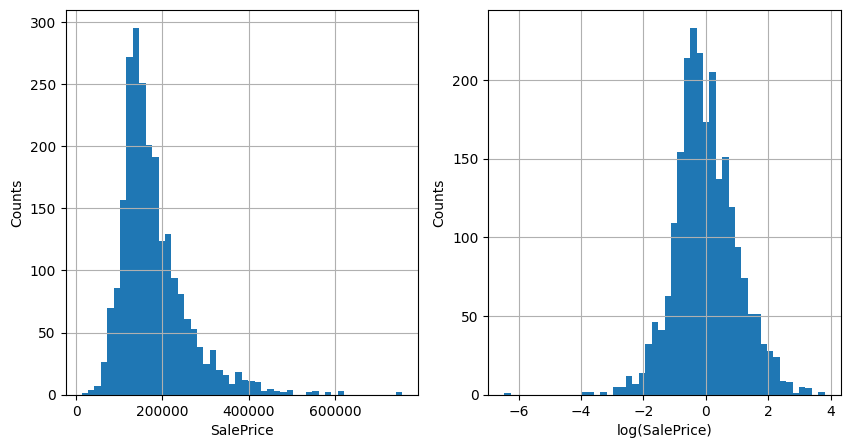

In [66]:
from sklearn.preprocessing import StandardScaler

fig, axs = plt.subplots(1,2, figsize=(10, 5))

df['SalePrice'].hist(bins=50, ax=axs[0])
axs[0].set_xlabel('SalePrice')
axs[0].set_ylabel('Counts')

saleprice_log = np.log(df['SalePrice'])


# Center and scale the log-transformed target
scaler_target = StandardScaler()
saleprice_log_scaled = scaler_target.fit_transform(saleprice_log.values.reshape(-1, 1)).flatten()

df['SalePrice_transf'] = saleprice_log_scaled
df['SalePrice_transf'].hist(bins=50, ax=axs[1])

axs[1].set_xlabel('log(SalePrice)')
axs[1].set_ylabel('Counts')

Observation:
- We observe that the distribution of the target variable resembles a skewed normal distribution
  
Solution:
- By applying a log transformation (shown in right-hand side plot), the new distribution more closely resembles a normal distributione
- We'll use the log transformed target variable for our model fitting


In [67]:
df.drop('SalePrice', axis=1, inplace=True)

## Nominal Features

 __Relationship with target variable__

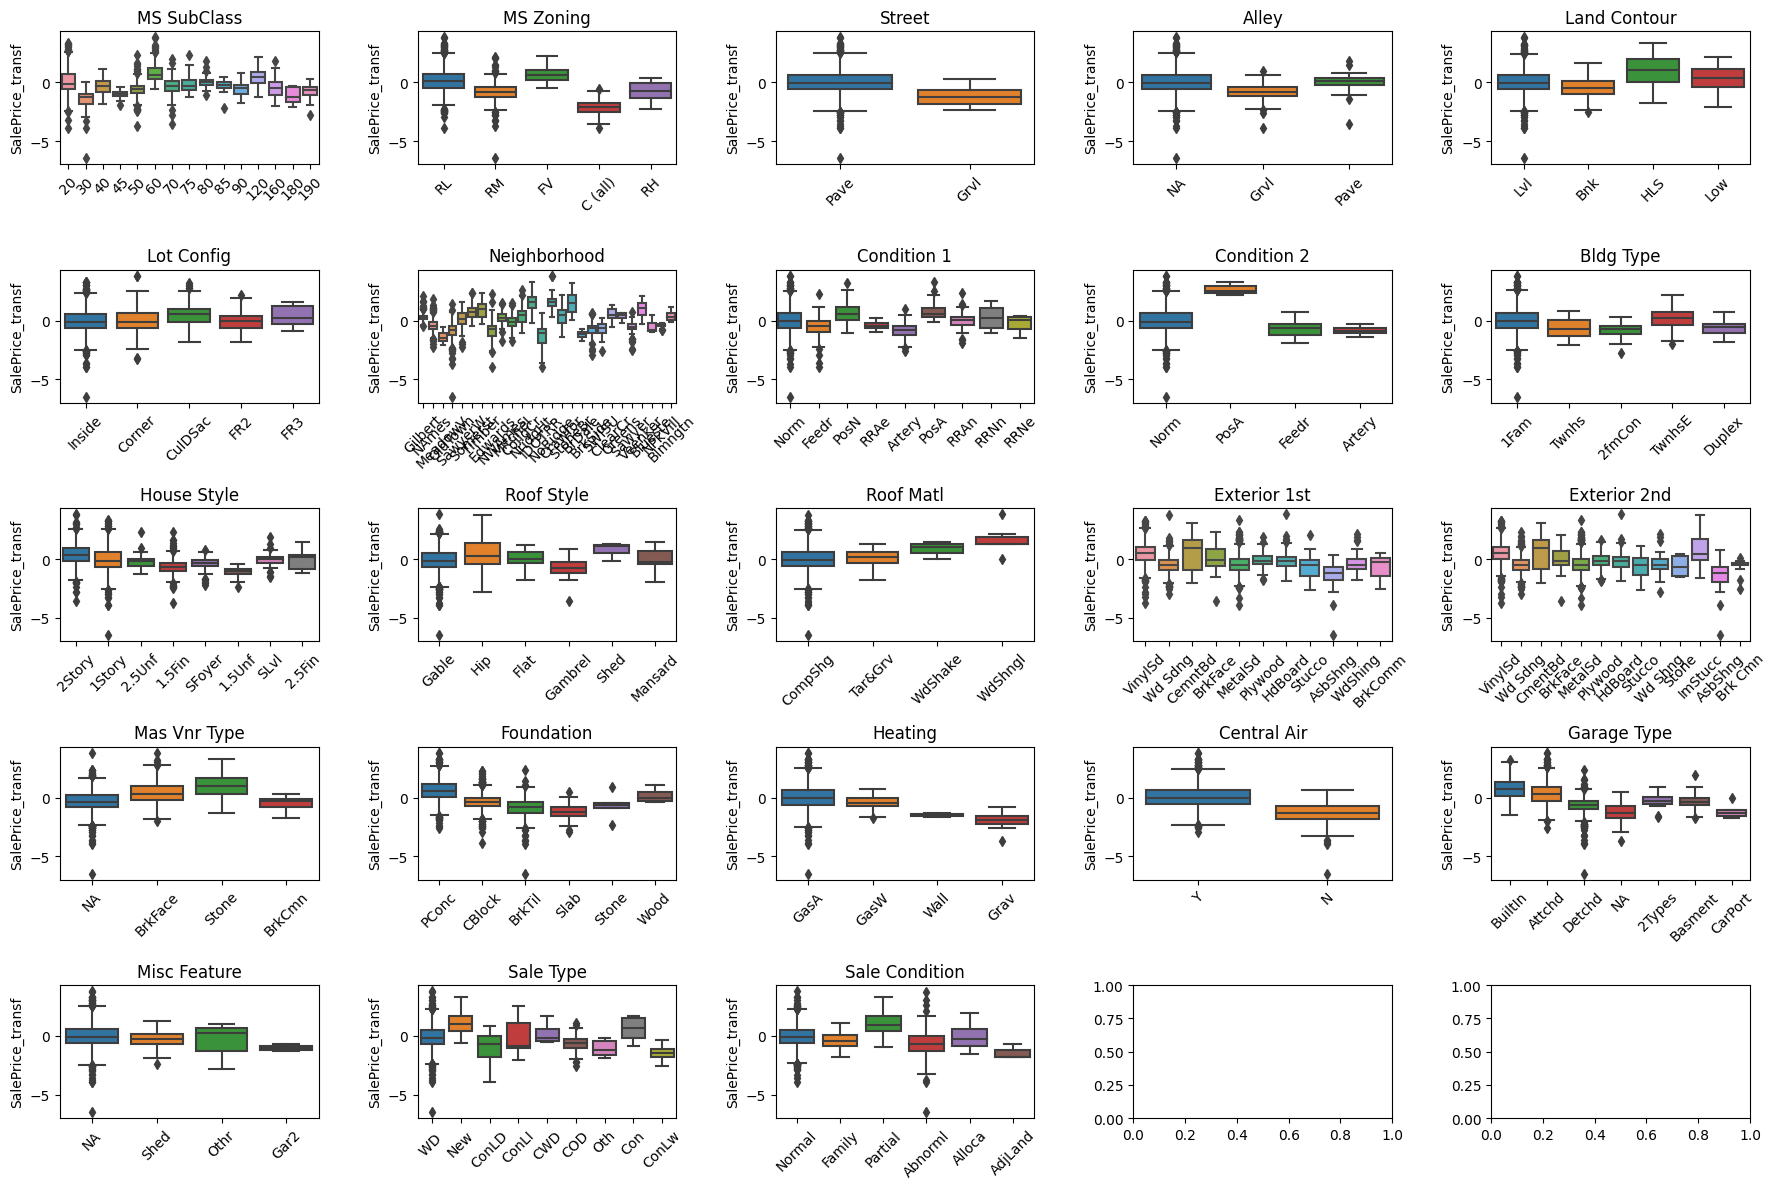

In [68]:
n_cols = 5
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 12))

for i, col in enumerate(nominal_features):
    r, c = np.divmod(i, n_cols)
    sns.boxplot(x=col, y='SalePrice_transf', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    for label in axs[r, c].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

Observations:
- The following features present a high number of categories: 'MS Subclass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd'. It could be interesting to group these in fewer categories as a function of 'Sale Price'
- Some features present little relationship with target variable: 'Lot Config', 'Misc Feature'. Maybe these could be dropped

Solution:
- We apply the grouping strategy to 'MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd'

In [69]:
feature_bins = {}

highcardinality_features = ['MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd']

# Derive the the new binning to reduce the cardinality of the features
for feature in highcardinality_features:
    
    # Calculate mean SalePrice for each category
    mean_sale_price = df.groupby(feature)['SalePrice_transf'].mean()

    # Bin the mean SalePrice into 4 groups
    bins = 5
    feature_bins[feature] = pd.qcut(mean_sale_price, q=bins, labels=[f"bin_{i+1}" for i in range(bins)])

In [70]:
def apply_grouphighcardinality(df):
    df = df.copy()
    for col, mapping in feature_bins.items():
        df[col] = df[col].map(mapping)  # Use -1 or any fill value for missing mappings
    return df

In [71]:
from sklearn.preprocessing import FunctionTransformer

# Wrap the function with FunctionTransformer
mapping_transformer = FunctionTransformer(apply_grouphighcardinality)

# Apply the pipeline to the data
df = mapping_transformer.fit_transform(df)
df[['MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd']].head()

,MS SubClass,Neighborhood,Exterior 1st,Exterior 2nd
0,bin_5,bin_3,bin_5,bin_5
1,bin_5,bin_2,bin_2,bin_2
2,bin_3,bin_1,bin_5,bin_5
3,bin_5,bin_2,bin_4,bin_4
4,bin_2,bin_1,bin_2,bin_2


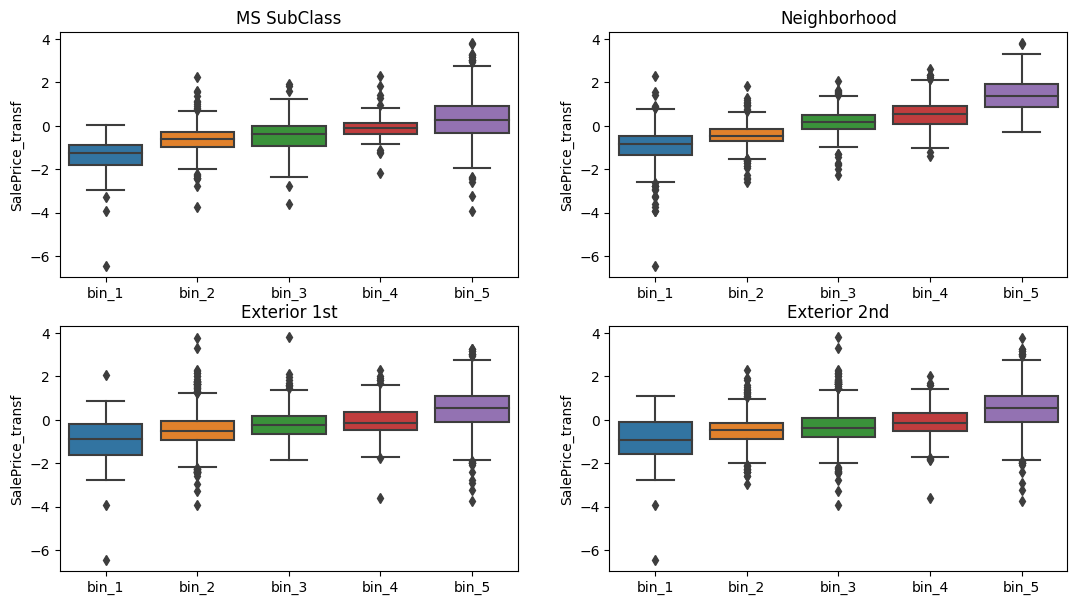

In [72]:
n_cols = 2
n_rows = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(13, 7))

for i, col in enumerate(['MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd']):
    r, c = np.divmod(i, n_cols)
    sns.boxplot(x=col, y='SalePrice_transf', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

We next adapt our lists of ordinal and nominal features to take into account the change of the variables we have just grouped

In [73]:
ordinal_features = ordinal_features + highcardinality_features
nominal_features = list(set(nominal_features) - set(highcardinality_features))

## Ordinal Features

Knowing in advance that these features have an ordinal nature provided by the dataset documentation, we decide to start right way with implementing the Ordinal Encoding. We also treat here the 4 new ordinal features we have created in the previous section. 

__Encoding__

First we collect the encoding order for the ordinal features from the documentation.

In [74]:
encoding_order_dict = {
    'Lot Shape': ['IR3', 'IR2', 'IR1', 'Reg'], 
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'Land Slope': ['Sev', 'Mod', 'Gtl'],
    'Overall Qual': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    'Overall Cond': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    'Exter Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Exter Cond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Exposure': ['NA', 'No', 'Mn', 'Av', 'Gd'], 
    'BsmtFin Type 1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFin Type 2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'Heating QC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'Kitchen Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'Fireplace Qu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Garage Finish': ['NA', 'Unf', 'RFn', 'Fin'],
    'Garage Qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Garage Cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Paved Drive': ['N', 'P', 'Y'],
    'Pool QC': ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    'MS SubClass': ['bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5'],
    'Neighborhood': ['bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5'],
    'Exterior 1st': ['bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5'],
    'Exterior 2nd': ['bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5'],
}

encoding_order = [encoding_order_dict[col] for col in ordinal_features]

We next apply the ordinal encoding with a ColumnTransformer, and also verify if the encoding was implemented correctly.

In [75]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinal_transformer = OrdinalEncoder(categories=encoding_order)

ordinalfeat_encoding = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_transformer, ordinal_features)
    ],
    remainder='passthrough',  # Keeps other columns as they are
    verbose_feature_names_out=False
)

transformed_data = ordinalfeat_encoding.fit_transform(df)

# Convert the result to a DataFrame for easy inspection
df = pd.DataFrame(transformed_data, columns=ordinalfeat_encoding.get_feature_names_out())
df[ordinal_features].head()

,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,...,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,MS SubClass,Neighborhood,Exterior 1st,Exterior 2nd
0,2.00,3.00,2.00,6.00,4.00,3.00,2.00,4.00,3.00,1.00,...,3.00,3.00,3.00,2.00,0.00,0.00,4.00,2.00,4.00,4.00
1,3.00,3.00,2.00,5.00,5.00,2.00,2.00,3.00,3.00,1.00,...,1.00,3.00,3.00,2.00,0.00,0.00,4.00,1.00,1.00,1.00
2,3.00,3.00,2.00,3.00,4.00,2.00,2.00,3.00,3.00,1.00,...,1.00,3.00,3.00,2.00,0.00,0.00,2.00,0.00,4.00,4.00
3,2.00,3.00,2.00,4.00,4.00,2.00,2.00,3.00,3.00,1.00,...,2.00,3.00,3.00,2.00,0.00,0.00,4.00,1.00,3.00,3.00
4,2.00,3.00,2.00,6.00,3.00,1.00,2.00,3.00,3.00,1.00,...,1.00,3.00,3.00,0.00,0.00,3.00,1.00,0.00,1.00,1.00


By comparing a few entries with the input dataset we confirm that the encoding was applied correctly

__Relationship with target variable__

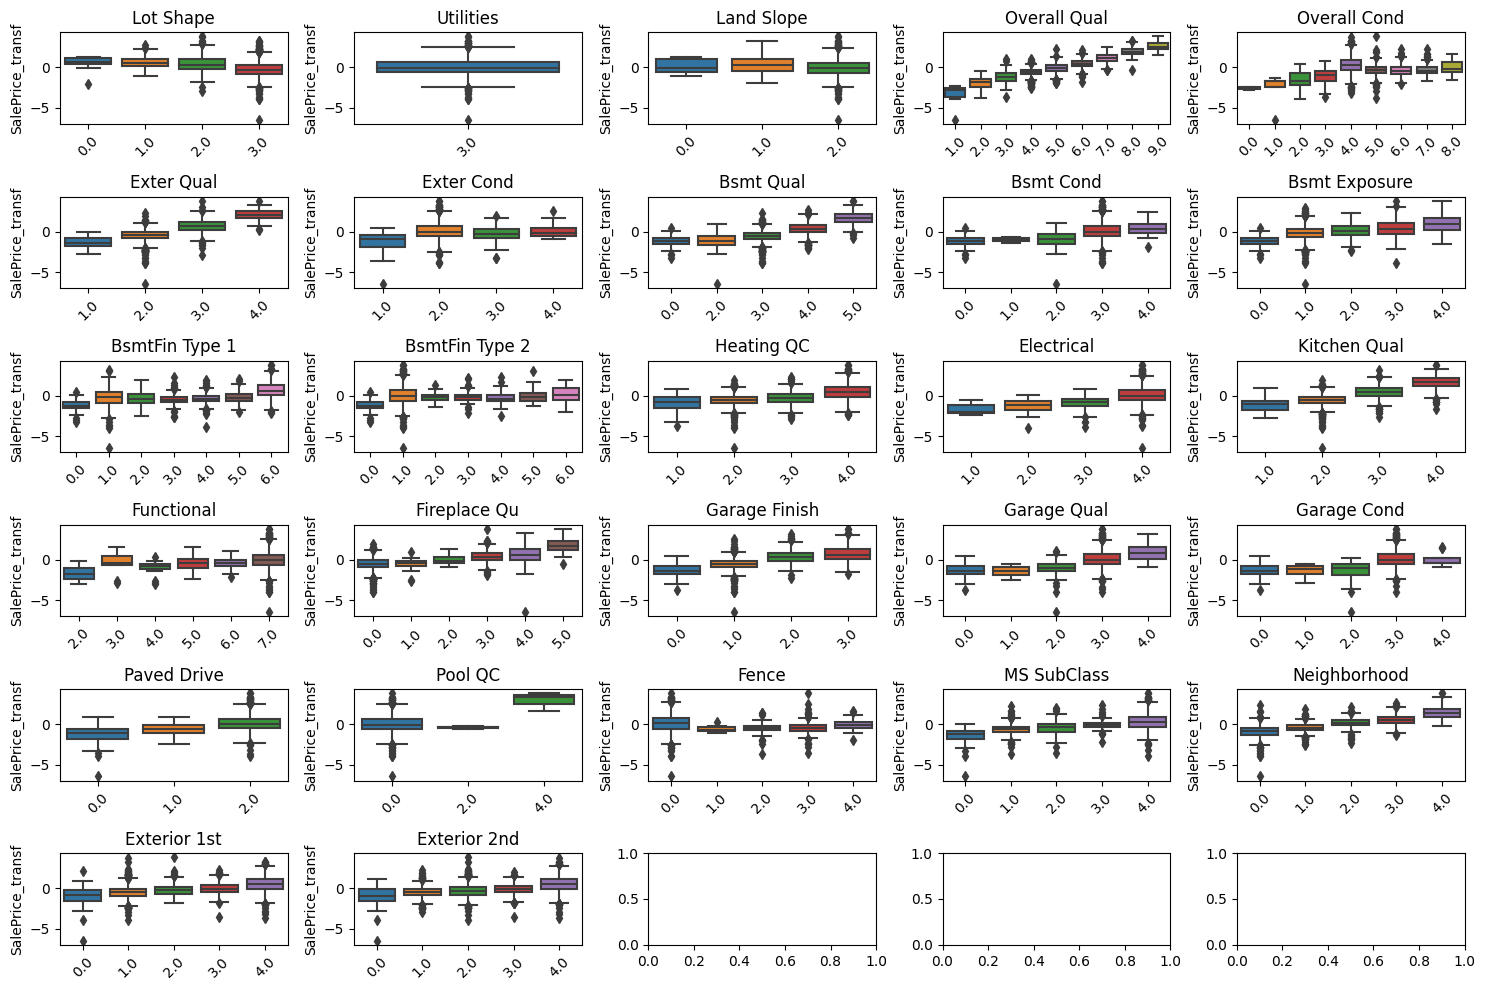

In [76]:
n_cols = 5
n_rows = 6

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, col in enumerate(ordinal_features):
    r, c = np.divmod(i, n_cols)
    sns.boxplot(x=col, y='SalePrice_transf', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    for label in axs[r, c].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

Observation:
- Feature 'Utilities' has a single category with entries and so can be dropped
- For many features the correlation seems very weak (e.g. 'Land Slope', 'Fence', etc.)
- For the features where there seems to be a stronger dependency, this seems to be compatible with a linear relationship which is compatible with the linear encoding we have just applied 


__Correlations with target variable__

In [77]:
# compute correlation of ordinal features with SalePrice
ordinal_corr = df[ordinal_features].corrwith(df['SalePrice_transf']).abs().sort_values(ascending=False)
print("Correlation of Ordinal Features SalePrice:")
print(ordinal_corr)

Correlation of Ordinal Features SalePrice:
Overall Qual     0.83
Neighborhood     0.75
Exter Qual       0.69
Kitchen Qual     0.67
Bsmt Qual        0.64
Garage Finish    0.60
Fireplace Qu     0.56
MS SubClass      0.51
Heating QC       0.49
Exterior 1st     0.44
Exterior 2nd     0.43
Bsmt Exposure    0.40
BsmtFin Type 1   0.38
Garage Qual      0.36
Paved Drive      0.36
Garage Cond      0.35
Lot Shape        0.33
Electrical       0.29
Bsmt Cond        0.27
Fence            0.17
Functional       0.14
Pool QC          0.09
Overall Cond     0.09
Land Slope       0.06
BsmtFin Type 2   0.01
Exter Cond       0.00
Utilities         NaN
dtype: float64


Observations:
- The features with highest predictin power > 0.5 are:
    - __'Overall Cond'__
    - __'Exter Qual'__
    - __'Kitchen Qual'__
    - __'Bsmt Qual'__
    - __'Garage Finish'__
    - __'Fireplace Qu'__
     
- The following features show a very low correlation with 'Sale Price' < 0.1: 
    - __'Utilities'__: should be dropped in any case since only one category is populated
    - __'Exter Cond'__
    - __'BsmtFin Type 2'__
    - __'Land Slope'__
    - __'Overall Cond'__
    - __'Pool QC'__: this provides a big effect but only when = 4 (Excellent pool quality)

Solution:  
- Drop __'Utilities'__,  __'Exter Cond'__, __'BsmtFin Type 2'__, __'Land Slope'__, __'Overall Cond'__.
- Replace __'Pool QC'__ with a binary new feature indicating whether a pool with excellent quality is present or not

In [78]:
df.drop(['Utilities', 'Exter Cond', 'BsmtFin Type 2', 'Land Slope', 'Overall Cond'], axis=1, inplace=True)

In [79]:
df['HasPool_Excellent'] = (df['Pool QC'] == 'Ex')
df.drop('Pool QC', axis=1, inplace=True)


In [80]:
ordinal_features = list(set(ordinal_features) - set(['Utilities', 'Exter Cond', 'BsmtFin Type 2', 'Land Slope', 'Overall Cond', 'Pool QC']))

## Discrete Features

__Relationship with target variable__

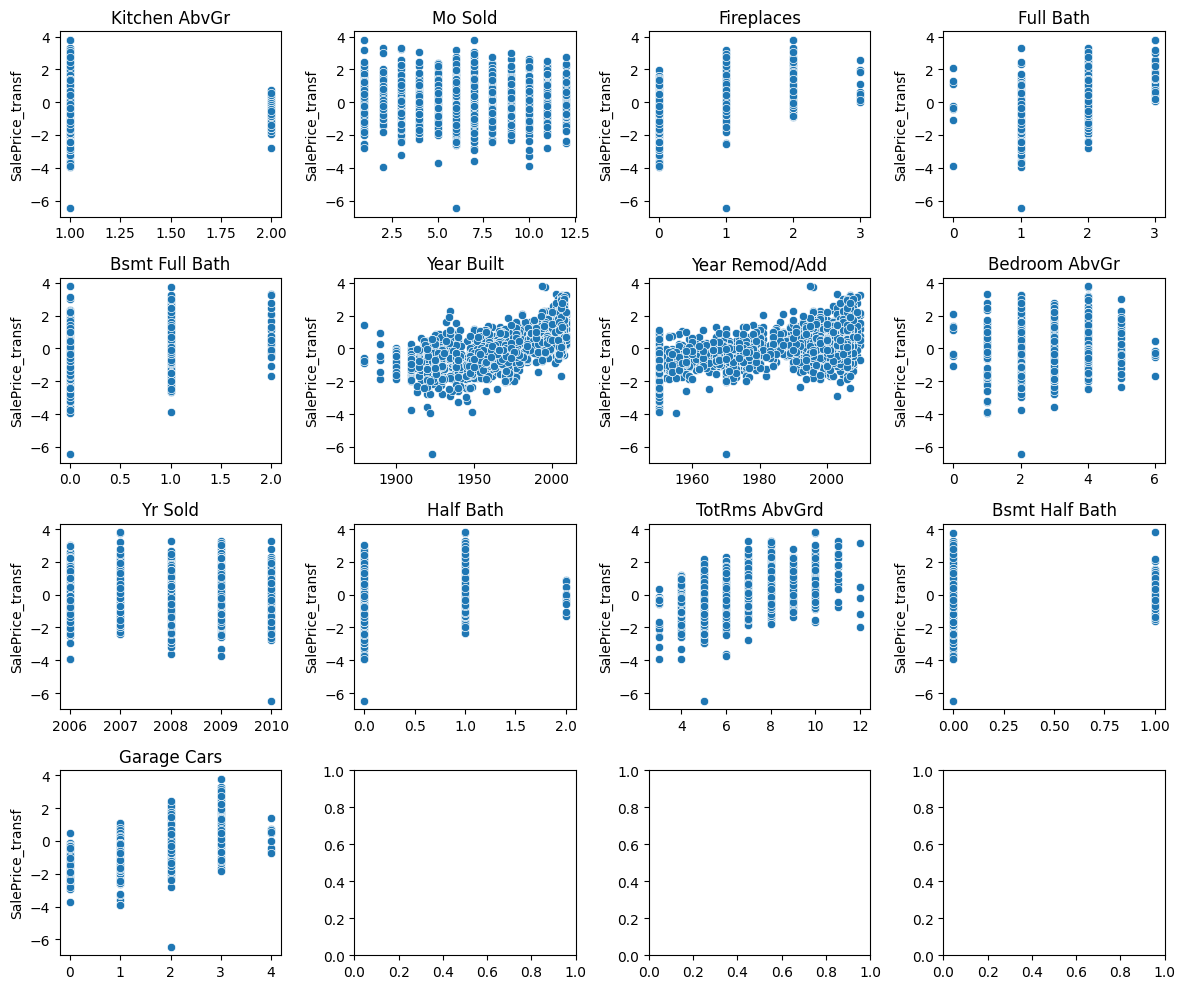

In [81]:
n_cols = 4
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,10))

for i, col in enumerate(discrete_features):
    r, c = np.divmod(i, n_cols)
    sns.scatterplot(x=col, y='SalePrice_transf', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')


plt.tight_layout()
plt.show()

__Correlation with target variable__

In [82]:
print("Correlation of Numerical Discrete features with SalePrice:")
df[discrete_features].corrwith(df['SalePrice_transf']).abs().sort_values(ascending=False)

Correlation of Numerical Discrete features with SalePrice:


Garage Cars      0.68
Year Built       0.63
Full Bath        0.59
Year Remod/Add   0.58
TotRms AbvGrd    0.50
Fireplaces       0.50
Half Bath        0.31
Bsmt Full Bath   0.27
Bedroom AbvGr    0.17
Kitchen AbvGr    0.14
Mo Sold          0.04
Yr Sold          0.02
Bsmt Half Bath   0.02
dtype: float64

Observations:
- __'Yr Sold'__, __'Bsmt Half Bath'__ and __'Mo Sold'__ present a very weak correlation

Solution:  
- Drop __'Yr Sold'__, __'Mo Sold'__ and __'Bsmt Half Bath'__

In [83]:
df.drop(['Yr Sold', 'Mo Sold', 'Bsmt Half Bath'], axis=1, inplace=True)
discrete_features = list(set(discrete_features) - set(['Yr Sold', 'Mo Sold', 'Bsmt Half Bath']))

## Continuous Features

__Relationship with target variable__

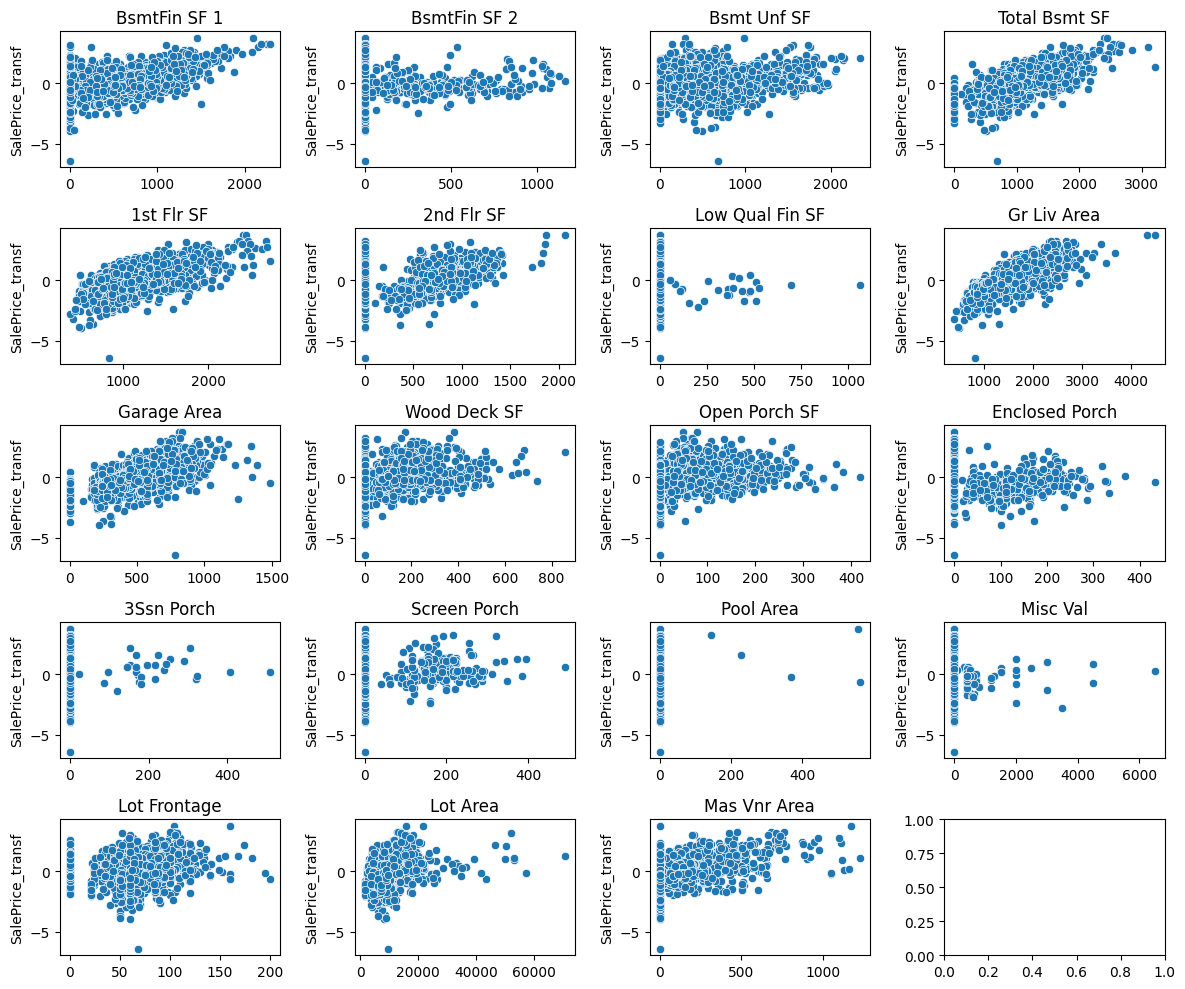

In [84]:
n_cols = 4
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,10))

for i, col in enumerate(continuous_features):
    r, c = np.divmod(i, n_cols)
    sns.scatterplot(x=col, y='SalePrice_transf', data=df, ax=axs[r, c])
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

__Correlation with target variable__

In [85]:
correlations = df[continuous_features].corrwith(df['SalePrice_transf']).abs().sort_values(ascending=False)
print("Correlation of numerical continuous features with SalePrice:")
print(correlations)

Correlation of numerical continuous features with SalePrice:
Gr Liv Area       0.73
Total Bsmt SF     0.66
Garage Area       0.65
1st Flr SF        0.63
Mas Vnr Area      0.47
BsmtFin SF 1      0.43
Open Porch SF     0.35
Lot Area          0.34
Wood Deck SF      0.33
2nd Flr SF        0.26
Bsmt Unf SF       0.20
Lot Frontage      0.19
Enclosed Porch    0.17
Screen Porch      0.11
Low Qual Fin SF   0.06
Pool Area         0.06
3Ssn Porch        0.05
Misc Val          0.04
BsmtFin SF 2      0.01
dtype: float64


__New Features__

Observation:

- We have previously said, when observing the histograms of these features, that for many to be replaced with binary feature, since they had most values at zero. 
- Now we confirm that most of these have they very week correlation with __'SalePrice'__
- However, for the following ones (__'2nd Flr SF'__,  __'Wood Deck SF'__, __'Open Porch SF'__, __'Mas Vnr Area'__) the correlation is not negligeble.

Solution:
- Create binary features from features which have most values at zero
- Drop the ones with very weak correlation and keep the others: 
    - Binarize and drop:
        - __'BsmtFin SF 2'__
        - __'Misc Val'__
        - __'3Ssn Porch'__
        - __'Low Qual Fin Sf'__
        - __'Screen Porch'__
        - __'Pool Area'__
        - __'Enclosed Porch'__
    - Binarize and keep:
        - __'2nd Flr SF'__
        - __'Wood Deck SF'__
        - __'Open Porch SF'__
        - __'Mas Vnr Area'__

In [86]:
# Columns to binarize and drop
binarize_drop_features = ['BsmtFin SF 2', 'Misc Val', '3Ssn Porch', 
                         'Low Qual Fin SF', 'Screen Porch', 'Pool Area', 'Enclosed Porch']

# Columns to binarize and keep
binarize_keep_features = ['2nd Flr SF', 'Wood Deck SF', 'Open Porch SF', 'Mas Vnr Area']

# Binarize the columns
for feature in binarize_drop_features:
    df[feature+'_binary'] = (df[feature] > 0).astype(int)
    df.drop(feature, axis=1, inplace=True)

for feature in binarize_keep_features:
    df[feature+'_binary'] = (df[feature] > 0).astype(int)    
    

In [87]:
continuous_features = list(set(continuous_features) - set(binarize_drop_features))

## Feature Encoding

We still need to encode the nominal features. This step will be performed during the model creating step using one-hot encoding.

# Dataset splitting

In [88]:
from sklearn.model_selection import train_test_split

# split the df dataset into training and validation sets
# Define the target variable and features
X = df.drop(columns='SalePrice_transf', axis=1)
y = df['SalePrice_transf']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 1396
Validation set size: 931


# Model Fitting

## Baseline model

The baseline model prediction is simply the mean of the 'Sale Price' for all entries, and does not depend on any of the features

In [89]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()

# Reshape target mean to fit the LinearRegression format (as a single feature)
pred_baseline_val_transf = np.full_like(y_val, fill_value=np.mean(y_train), dtype=float)

pred_baseline_val_log = scaler_target.inverse_transform(pred_baseline_val_transf.reshape(-1, 1)).flatten()

pred_baseline_val = np.exp(pred_baseline_val_log)


## Simple Model

Observation:
- The 3 variables with the highest correlation values with 'SalePrice_log' are:
    - __'Overall Qual'__: 0.83
    - __'Gr Liv Area'__: 0.73
    - __'Garage Cars'__: 0.68

Solution:  
- Use these features in the simple model as may provide higehet prediction power
- A StandardScaling step is implemented as preprocessing step in order to make sure all features contribution are on the same scale

In [90]:
# Set up transformers
onehot_encoder = OneHotEncoder(sparse_output=False)
ordinal_encoder = OrdinalEncoder(categories=encoding_order)
scaler = StandardScaler()

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', scaler, ['Overall Qual','Gr Liv Area','Garage Cars'])  # Scale continuous and discrete features
    ],
    remainder='passthrough' 
)

# Set up the pipeline with preprocessing and the linear regression model
pipe_simple = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Separate features and target variable
X = X_train[['Overall Qual', 'Gr Liv Area', 'Garage Cars']]
y = y_train  # Replace 'SalePrice' with the actual target variable name

# Fit the pipeline on the training data
pipe_simple.fit(X, y)

# Make predictions on the validation data
pred_simple_val_transf = pipe_simple.predict(X_val[['Overall Qual', 'Gr Liv Area', 'Garage Cars']])

# Apply inverse transformation to get the actual SalePrice
pred_simple_val_log = scaler_target.inverse_transform(pred_simple_val_transf.reshape(-1, 1)).flatten()
pred_simple_val = np.exp(pred_simple_val_log)


## Intermediate Model

For this model we select the features that present the highest correlation factors with the target variable. We additionally select nominal features which visually seem to provide for bigger prediction power. A one-hot encoding is applied to the nominal features.

Below the list of variables to use:

- Nominal Features
    - MS Zoning	
    - Condition 2
    - Roof Matl
    - Foundation
    - Heating
    - Central Air

- Ordinal Features
    - Overall Qual:     0.80
    - Neighborhood:     0.71
    - Exter Qual:       0.71
    - Kitchen Qual:     0.68
    - Bsmt Qual:        0.61
    - Garage Finish:    0.56
    - Fireplace Qu:     0.54


- Discrete Features
    - Garage Cars:      0.68
    - Year Built:       0.63
    - Full Bath:        0.59
    - Year Remod/Add:   0.58
    - TotRms AbvGrd:    0.50
    - Fireplaces:       0.50


- Continuous Features
    - Gr Liv Area:      0.73
    - Total Bsmt SF:    0.66
    - Garage Area:      0.65
    - 1st Flr SF:       0.63

In [91]:
# Define selected features based on correlation and prediction power
intermediate_nominal_features = ['MS Zoning', 'Condition 2', 'Roof Matl', 'Foundation', 'Heating', 'Central Air']
intermediate_ordinal_features = ['Overall Qual', 'Neighborhood', 'Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'Garage Finish', 'Fireplace Qu']
intermediate_discrete_features = ['Garage Cars', 'Year Built', 'Full Bath', 'Year Remod/Add', 'TotRms AbvGrd', 'Fireplaces']
intermediate_continuous_features = ['Gr Liv Area', 'Total Bsmt SF', 'Garage Area', '1st Flr SF']

# Set up transformers
onehot_encoder = OneHotEncoder(sparse_output=False)  # Drop first to avoid multicollinearity
ordinal_encoder = OrdinalEncoder(categories=encoding_order)
scaler = StandardScaler()

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_encoder, intermediate_nominal_features),        # One-hot encode nominal feature
        ('scale', scaler, intermediate_discrete_features + intermediate_continuous_features)  # Scale continuous and discrete features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

# Set up the pipeline with preprocessing and the linear regression model
pipe_intermediate = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Separate features and target variable
X = X_train[intermediate_nominal_features + intermediate_ordinal_features + intermediate_discrete_features + intermediate_continuous_features]
y = y_train  # Replace 'SalePrice' with the actual target variable name

# Fit the pipeline on the training data
pipe_intermediate.fit(X, y)

# Make predictions on the test data
pred_intermediate_val_transf = pipe_intermediate.predict(X_val[intermediate_nominal_features + intermediate_ordinal_features + intermediate_discrete_features + intermediate_continuous_features])

# Apply inverse transformation to get the actual SalePrice
pred_intermediate_val_log = scaler_target.inverse_transform(pred_intermediate_val_transf.reshape(-1, 1)).flatten()
pred_intermediate_val = np.exp(pred_intermediate_val_log)


## Complex Model

When implementing a more complex model taking into account all of the features in the available dataset, one much realize many of the features provide redundant or linear dependent information. For example, features like 'Total Bsmt SF' and 'Gr Liv Area' are likely correlated as they both measure areas of the house. Redundant features may potentially generate overfitting problems, and produce models worse at generalizing in unkown data. 

Regularization techniques, such Ridge regression, help mitigate this issue. Helping to fight overfitting and to improve the generalizability of a model. 

 Ridge regression (L2 Regularization) penalizes large model coefficients, which helps prevent overfitting, by adding a penalyt term to the cost function which is proportional to the square of the coefficients. 

In [92]:
from sklearn.linear_model import Ridge

# Set up transformers
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')  # Drop first to avoid multicollinearity
ordinal_encoder = OrdinalEncoder(categories=encoding_order)
scaler = StandardScaler()

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', onehot_encoder,  nominal_features),        # One-hot encode nominal feature
        ('scale', scaler, discrete_features + continuous_features)  # Scale continuous and discrete features
    ],
    remainder='passthrough'  # Pass through any other columns unchanged
)

alpha = 25.95

# Set up the pipeline with preprocessing and the linear regression model
pipe_complex = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=alpha))
])

# Fit the pipeline on the training data
pipe_complex.fit(X_train, y_train)

# Make predictions on the validation data
pred_complex_val_transf = pipe_complex.predict(X_val)

# Apply inverse transformation to get the actual SalePrice
pred_complex_val_log = scaler_target.inverse_transform(pred_complex_val_transf.reshape(-1, 1)).flatten()
pred_complex_val = np.exp(pred_complex_val_log)

# Evaluation metric

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score#, root_mean_squared_error

def evaluate_metric(y_pred, y_test):
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    #rms = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Print MAE in dollars
    print(f" - MAE: {mae/1000:.3f} thousand dollars")
    #print(f"Root Mean Squared Error (RMSE): {rms/1000:.3f} dollars")
    print(f" - R^2: {r2:.2f}")
    
    return mae, r2

In [94]:
y_val_true = np.exp(scaler_target.inverse_transform(y_val.values.reshape(-1, 1)).flatten())

print(f'Baseline Model (Mean value):')
mae_baseline, r2_baseline = evaluate_metric(pred_baseline_val, y_val_true)
print(f'Simple Model (Linear Regression):')
mae_simple, r2_simple = evaluate_metric(pred_simple_val, y_val_true)
print(f'Intermediate Model (Linear Regression):')
mae_intermediate, r2_intermediate = evaluate_metric(pred_intermediate_val, y_val_true)
print(f'Complex Model (Ridge Regression alpha={alpha}):')
mae_complex, r2_complex = evaluate_metric(pred_complex_val, y_val_true)

Baseline Model (Mean value):
 - MAE: 53.969 thousand dollars
 - R^2: -0.05
Simple Model (Linear Regression):
 - MAE: 22.485 thousand dollars
 - R^2: 0.82
Intermediate Model (Linear Regression):
 - MAE: 16.784 thousand dollars
 - R^2: 0.89
Complex Model (Ridge Regression alpha=25.95):
 - MAE: 14.335 thousand dollars
 - R^2: 0.92


# Regularization

The alpha parameter in Ridge regression is an hyperparameter, which needs to be chosen by us and is not a learnt parameter. For this we'll perform a grid search by fitting and evaluating different models for varying values of alpha.

In [95]:
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=100):
    # Create/fit the pipeline
    pipe_complex = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha))
])
    pipe_complex.fit(X_train, y_train)

    # Save model and its performance on train/test sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mae": mean_absolute_error(y_train, pipe_complex.predict(X_train)),
            "val_mae": mean_absolute_error(y_val, pipe_complex.predict(X_val)),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)


Next we plot the validation curves. For each alpha we plot the MAE score of the train a validation sets.

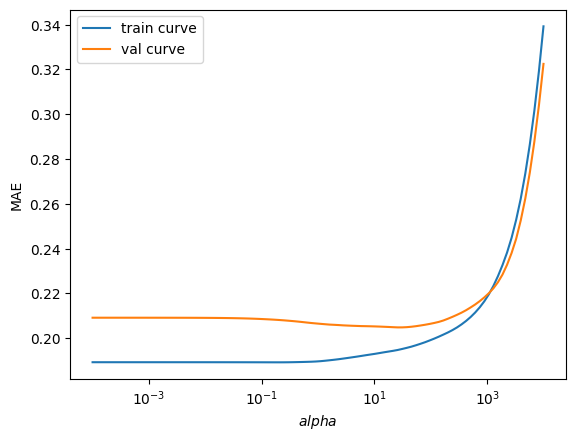

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.semilogx(gs_results["alpha"], gs_results["train_mae"], label="train curve")
plt.semilogx(gs_results["alpha"], gs_results["val_mae"], label="val curve")
plt.xlabel("$alpha$")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [97]:
print("Alpha value for minimum in validation set MAE curve:")
print(f"alpha = {gs_results['alpha'].iloc[gs_results['val_mae'].idxmin()]:.2f}")

Alpha value for minimum in validation set MAE curve:
alpha = 25.95


Observation:  
 
- At low values of alpha, there is a wider gap between the training and validation curves, which suggests overfitting of the model.
- At alpha=25.95 the validation curve reached its minimum which should correspond to the optimal tradeoff between model accuracy and generalization capability.
- As alpha increases, from alpha=100, there's a steep loss of prediction power of the model, indicating significant underfitting.

# Model Comparison

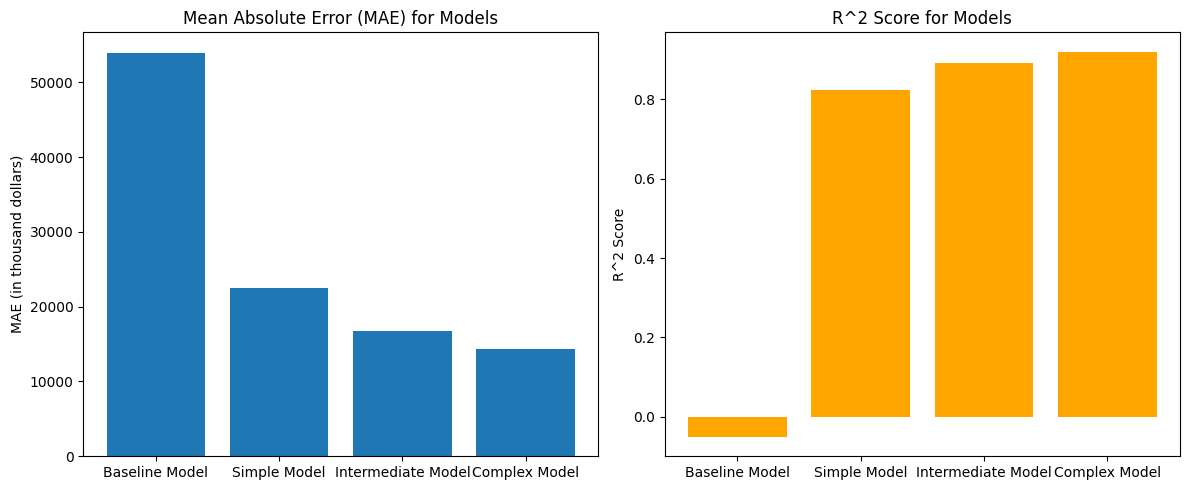

In [98]:
# Data for the models
models = ["Baseline Model", "Simple Model", "Intermediate Model", "Complex Model"]
mae_values = [mae_baseline, mae_simple, mae_intermediate, mae_complex]  # in thousand dollars
r2_values = [r2_baseline, r2_simple, r2_intermediate, r2_complex]

# Plot 1: MAE for each model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mae_values)
plt.ylabel("MAE (in thousand dollars)")
plt.title("Mean Absolute Error (MAE) for Models")

# Plot 2: R^2 for each model
plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color='orange')
plt.ylabel("R^2 Score")
plt.title("R^2 Score for Models")

# Display the plots
plt.tight_layout()
plt.show()

The previous plot demonstrates the performance progression across four models, with clear improvements as model complexity increases. 

- The Baseline Model, which uses only the mean value as a prediction, shows the highest Mean Absolute Error (MAE) at approximately 54 thousand dollars and a negative R^2 score, indicating that it fails to capture any meaningful pattern in the data.

- The Simple Model using basic linear regression with independent variables __'Overall Qual'__, __'Gr Liv Area'__ and __'Garage Cars'__, reduces the MAE significantly to about 22.5 thousand dollars and achieves a strong R^2=0.82, demonstrating that even a model with very few variables, but which present a high correlation with target variable, can capture much of the data's variance.

- The Intermediate Model adds additional features, in a total of 23 of all different datatypes, presenting the highest correlation with target variable. This achieves a MAE of around 16.8 thousand dollars and an improved R^2 = 0.89. This enhancement shows the value of adding relevant predictors to the model.

- Finally, the Complex Model, which uses Ridge regression with optimized regularization (alpha = 25.95), achieves the lowest MAE at 14.3 thousand dollars and the highest R^2=0.92. This improvement suggests that using all features, including many that are correlated together with regularization effectively improves the model while mitigating overfitting, leading to better generalization